In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [27]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Asset Allocation in Python
- 자산 배분이란 투자자의 총 투자액을 특정 자산(주식, 옵션, 채권 또는 기타 금융 상품)에 분산시키는 것을 의미한다.
- 배분을 고려할 때 투자자는 위험과 잠재적 보상 사이의 균형을 유지하려고 한다.
- 동시에 배분은 개별 목표(예상 수익률), 위험 허용치(투자자가 수용할 위험 정도) 또는 투자 기간(단기 또는 장기 투자)과 같은 요인에 따라 달라진다.

- 자산 배분의 핵심 프레임워크는 현대 포트폴리오 이론(MPT(Modern Portfolio Theory))이며, 평균-분산 분석이라고도 한다.
- MPT는 특정 위험 수준에 대해 기대 수익률(이익)을 극대화하고자 위험을 피하며 포트폴리오를 구성하는 방법.
- MPT의 주요 통찰은 투자자는 자산 성과(예상 수익률이나 변동성과 같은 지표로만)만 평가하지 말고 여러 지표가 자산 포트폴리오의 성과에 어떤 영향을 미치는지 조사해야 한다는 것이다.
- MPT는 다각화 개념과 밀접한 관련이 있다. 이는 단순히 다른 종류의 자산을 소유하는 것만으로도 위험이 줄어든다는 의미다
- 즉 다각화를 통해 개별 주식으로부터의 손실이나 이익이 포트폴리오 전체의 성능에 미치는 영향이 줄어들기 때문이다.

- 최적화된 자산 배분 덕분에 포트폴리오 내 개별 자산 중 가장 낮은 변동성을 가진 것보다 더 변동성이 낮은 포트폴리오를 가질 수 있다는 것이다.
- 원칙적으로 보유 자산 간의 상관관계가 낮을수록 다각화에는 더 좋다.
- 완벽한 음의 상관관계를 통해 모든 위험을 다각화할 수 있다.

### 현대 포트폴리오 이론의 주요 가정
- 투자자는 합리적이고 수익을 극대화하는 동시에 가능한 한 위험을 피하는 것을 목표로 한다.
- 투자자들은 기대 수익을 극대화하려는 목표를 공유한다.
- 모든 투자자는 잠재적 투자에 대해 동일한 수준의 정보를 보유한다.
- 커미션, 세금, 거래 비용은 고려되지 않는다.
- 투자자는 무위험 금리로 (무제한) 돈을 빌리거나 빌려 줄 수 있다.

### 대부분의 프레임워크를 동일하게 유지한 채 일부 코드만 약간 수정하면 다양한 목적 함수에 적용할 수 있다.

### 이번 장에서는
- 기본 1/n 포트폴리오 성능 평가
- 몬테카를로 시뮬레이션을 사용해 효율적 경계선 찾기
- scipy의 최적화를 통해 효율적 경계선 찾기
- cvxpy의 컨벡스(convex) 최적화를 통해 효율적 경계선 찾기

## Evaluating the performance of a basic 1/n portfolio
- 기본 1/n 포트폴리오의 성능 평가

### How to do it...

1. Import the libraries:

In [5]:
# ! pip install pyfolio

In [2]:
import yfinance as yf
import numpy as npresult.prices.rolling(window=mdd_period).max()
import pandas as pd
import pyfolio as pf

c:\ai\pythonproject\venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


2. Set up the parameters:

In [3]:
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT', 'TWTR']
START_DATE = '2017-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)
n_assets

4

3. Download the stock prices from Yahoo Finance:

[*********************100%***********************]  4 of 4 completed
Downloaded 501 rows of data.


<AxesSubplot:title={'center':'Stock prices of the considered assets'}, xlabel='Date'>

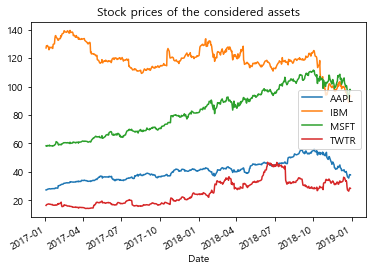

In [4]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
prices_df['Adj Close'].plot(title='Stock prices of the considered assets')

4. Calculate individual asset returns:

In [5]:
returns = prices_df['Adj Close'].pct_change().dropna()
returns.head()

AAPL       IBM      MSFT      TWTR
Date                                              
2017-01-04 -0.001119  0.012381 -0.004474  0.025547
2017-01-05  0.005085 -0.003309  0.000000  0.013642
2017-01-06  0.011148  0.004920  0.008668  0.004681
2017-01-09  0.009159 -0.011089 -0.003183  0.019220
2017-01-10  0.001008 -0.012705 -0.000319 -0.007429

5. Define the weights:
- 가중치 정의

In [6]:
portfolio_weights = n_assets * [1 / n_assets]
portfolio_weights

[0.25, 0.25, 0.25, 0.25]

In [17]:
returns.T

Date  2017-01-04  2017-01-05  2017-01-06  2017-01-09  2017-01-10  2017-01-11  \
AAPL   -0.001119    0.005085    0.011148    0.009159    0.001009    0.005373   
IBM     0.012381   -0.003309    0.004920   -0.011090   -0.012705    0.013472   
MSFT   -0.004474    0.000000    0.008668   -0.003183   -0.000319    0.009103   
TWTR    0.025547    0.013642    0.004681    0.019220   -0.007429   -0.004030   

Date  2017-01-12  2017-01-13  2017-01-17  2017-01-18  ...  2018-12-14  \
AAPL   -0.004175   -0.001761    0.008065   -0.000083  ...   -0.031998   
IBM     0.001193   -0.003632    0.003287   -0.006493  ...   -0.006875   
MSFT   -0.009179    0.001437   -0.002711   -0.000480  ...   -0.031247   
TWTR    0.004624   -0.007480   -0.016812    0.008844  ...   -0.000557   

Date  2018-12-17  2018-12-18  2018-12-19  2018-12-20  2018-12-21  2018-12-24  \
AAPL   -0.009306    0.012992   -0.031191   -0.025235   -0.038896   -0.025874   
IBM    -0.031693    0.004737   -0.001886   -0.029288   -0.018404   -0.030377   
MSFT   -0.029614    0.010497   -0.002693   -0.021024   -0.032312   -0.041739   
TWTR   -0.068023    0.009273   -0.024007   -0.110537   -0.067600   -0.031490   

Date  2018-12-26  2018-12-27  2018-12-28  
AAPL    0.070421   -0.006490    0.000512  
IBM     0.035512    0.021456   -0.006592  
MSFT    0.068310    0.006166   -0.007808  
TWTR    0.083554    0.000698   -0.008717  

[4 rows x 500 columns]

6. Calculate portfolio returns:
- 포트폴리오 수익률 계산

In [11]:
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), 
                              index=returns.index)
portfolio_returns

Date
2017-01-04    0.008084
2017-01-05    0.003855
2017-01-06    0.007354
2017-01-09    0.003527
2017-01-10   -0.004861
                ...   
2018-12-21   -0.039303
2018-12-24   -0.032370
2018-12-26    0.064449
2018-12-27    0.005457
2018-12-28   -0.005651
Length: 500, dtype: float64

In [12]:
len(portfolio_returns)

500

1. Import the libraries:

In [20]:
import yfinance as yf
import numpy as np
import pandas as pd

2. Set up the parameters:
매개변수 생성

In [21]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
RISKY_ASSETS = ['FB', 'TSLA', 'TWTR', 'MSFT']
RISKY_ASSETS.sort() # 목록을 알파벳 순으로 정렬(목록 순서와 다운로드 순서가 다를 때 문제가 될 수 있다.
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

3. Download the stock prices from Yahoo Finance:

In [22]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  4 of 4 completed
Downloaded 250 rows of data.


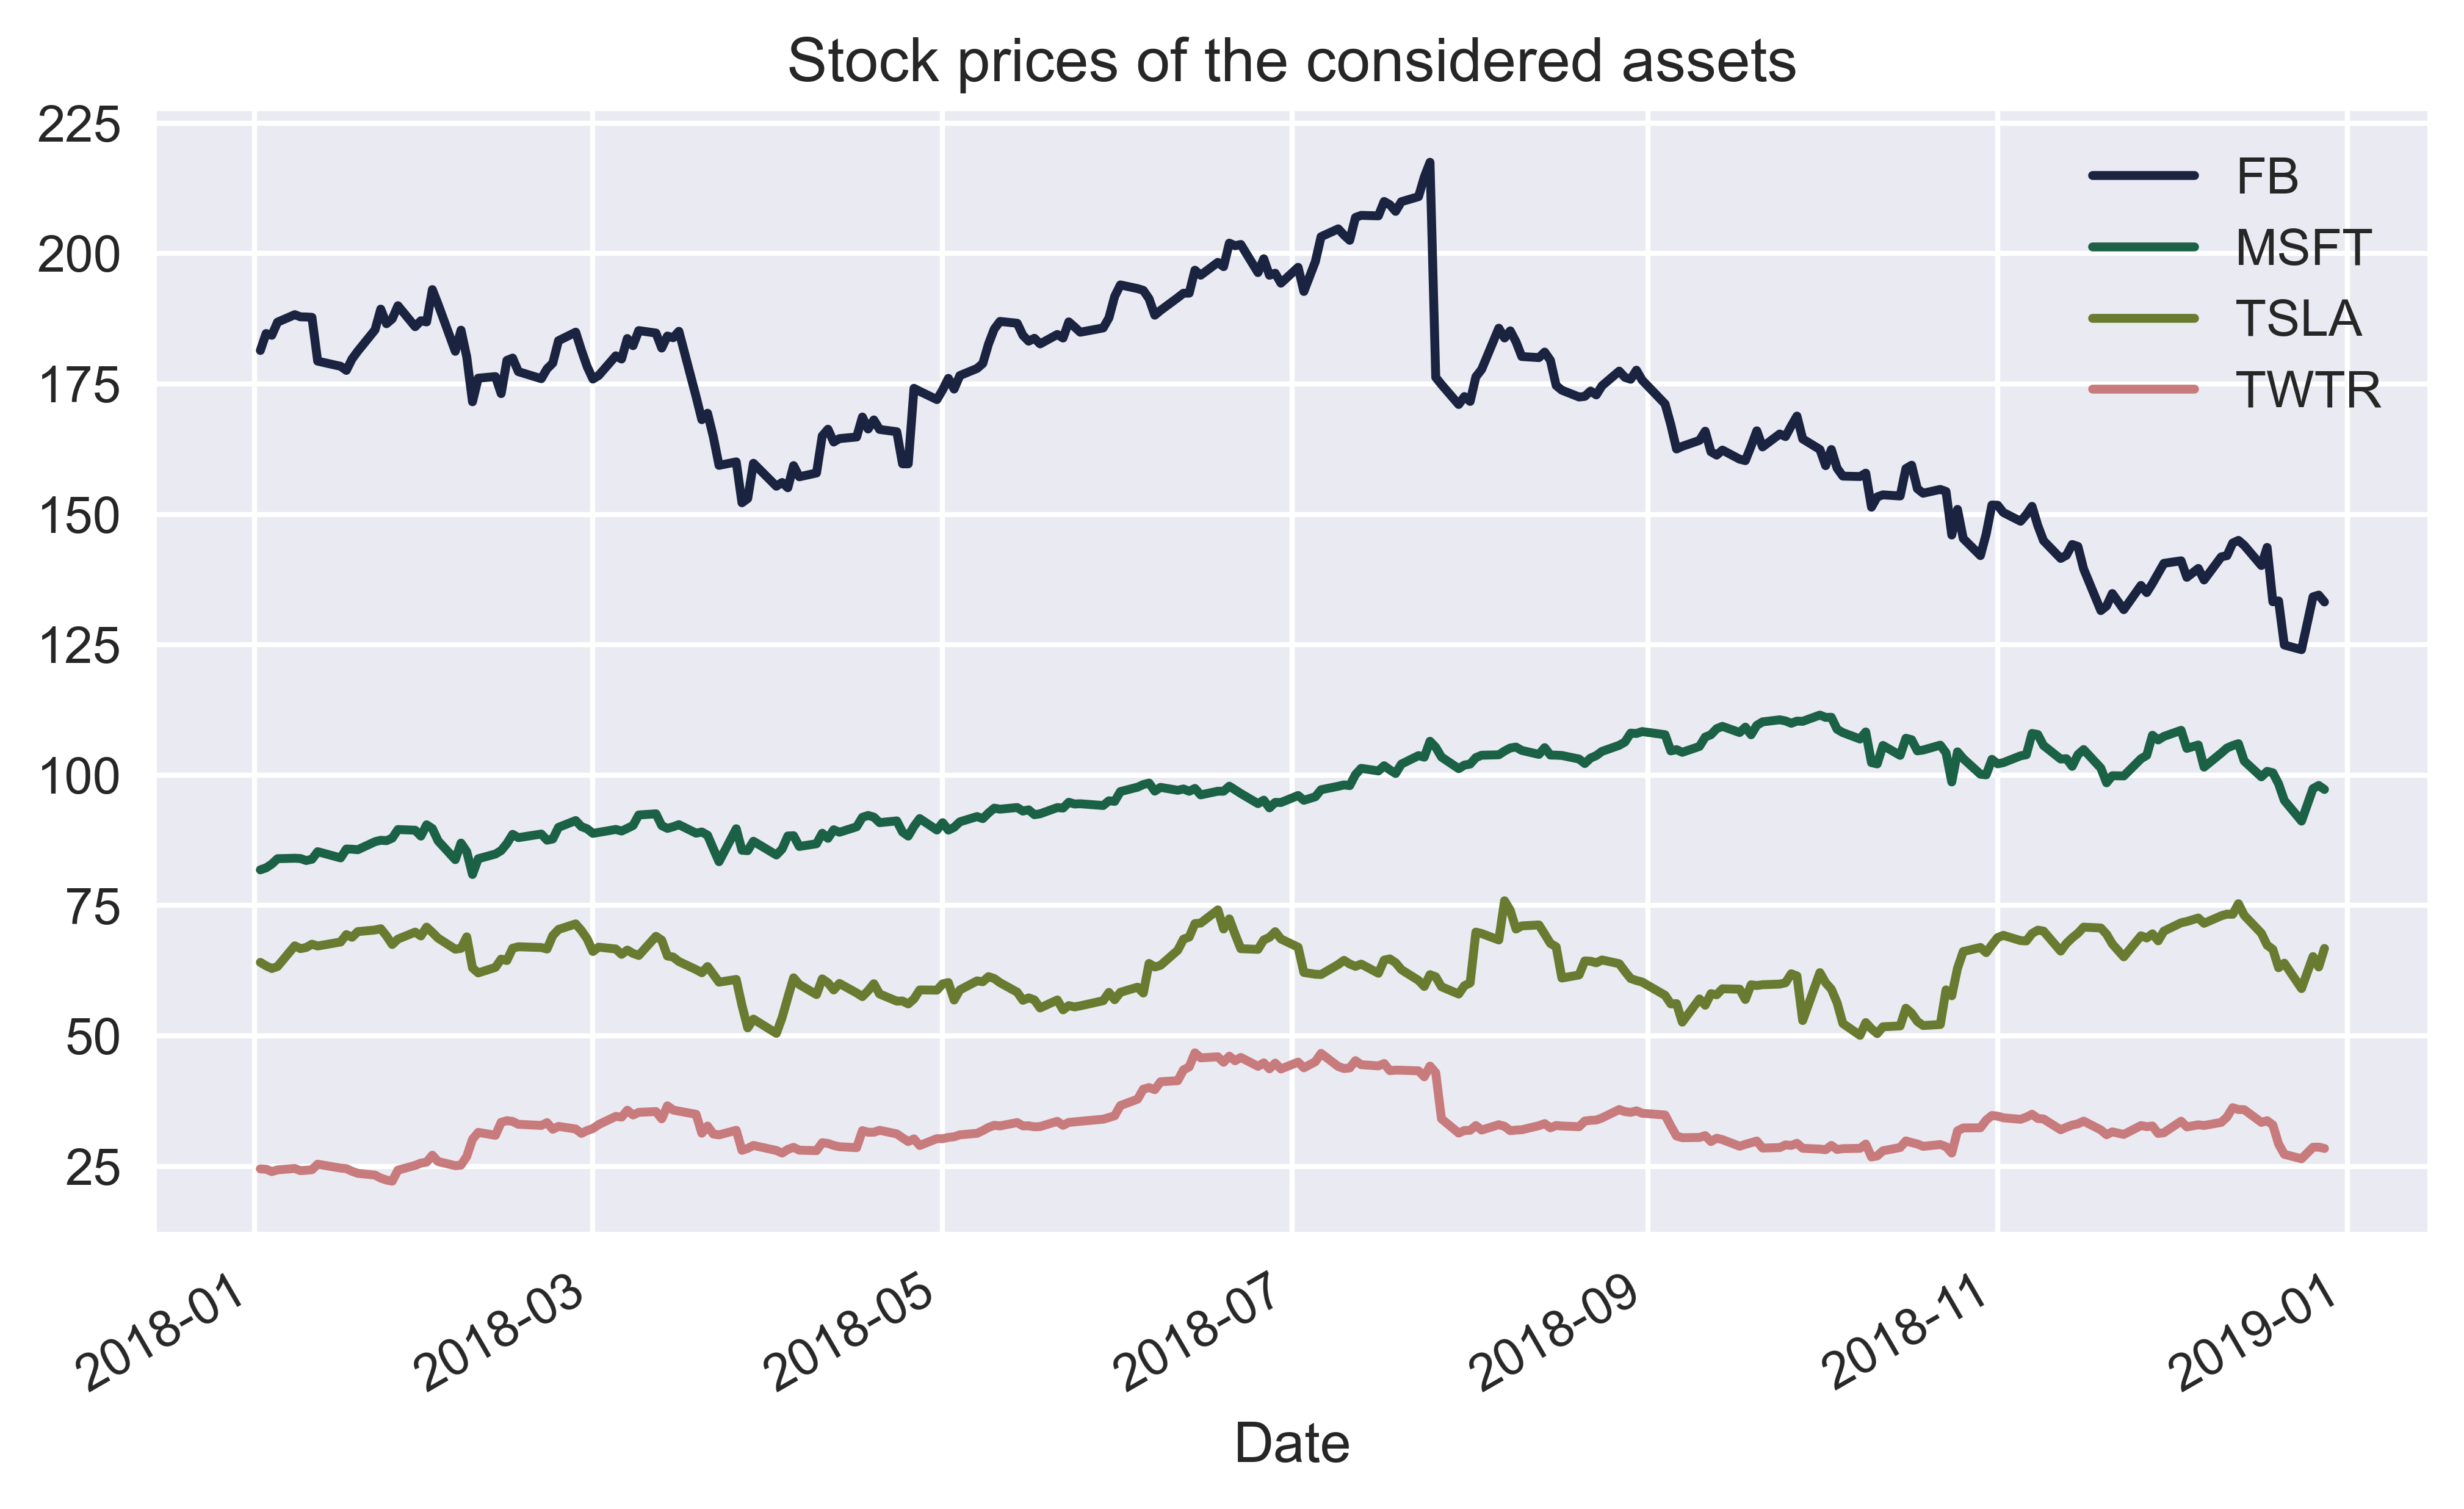

In [28]:
prices_df['Adj Close'].plot(title='Stock prices of the considered assets');

4. Calculate annualized average returns and the corresponding standard deviation:
- 연납화 평균 수익률과 해당 표준 편차를 계산한다.(연납화 : 연 기준으로 환산해서 보여주는)
- 잠재적 포트폴리오를 평가하려면 평균 연간 수익률과 해당 공분산 행렬이 필요하다.
- mean(), cov()
- 변동성을 계산하고자 공분산 행렬이 필요했으며, 자산 간의 상관관계도 고려해야한다.
- 상당한 다각화로 이익을 얻으려면 자산의 양의 상관관계가 낮거나 음의 상관관계를 가져야한다.

In [24]:
returns_df = prices_df['Adj Close'].pct_change().dropna() # 단순 수익률 계산

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [31]:
avg_returns

FB     -0.237618
MSFT    0.214581
TSLA    0.210151
TWTR    0.319659
dtype: float64

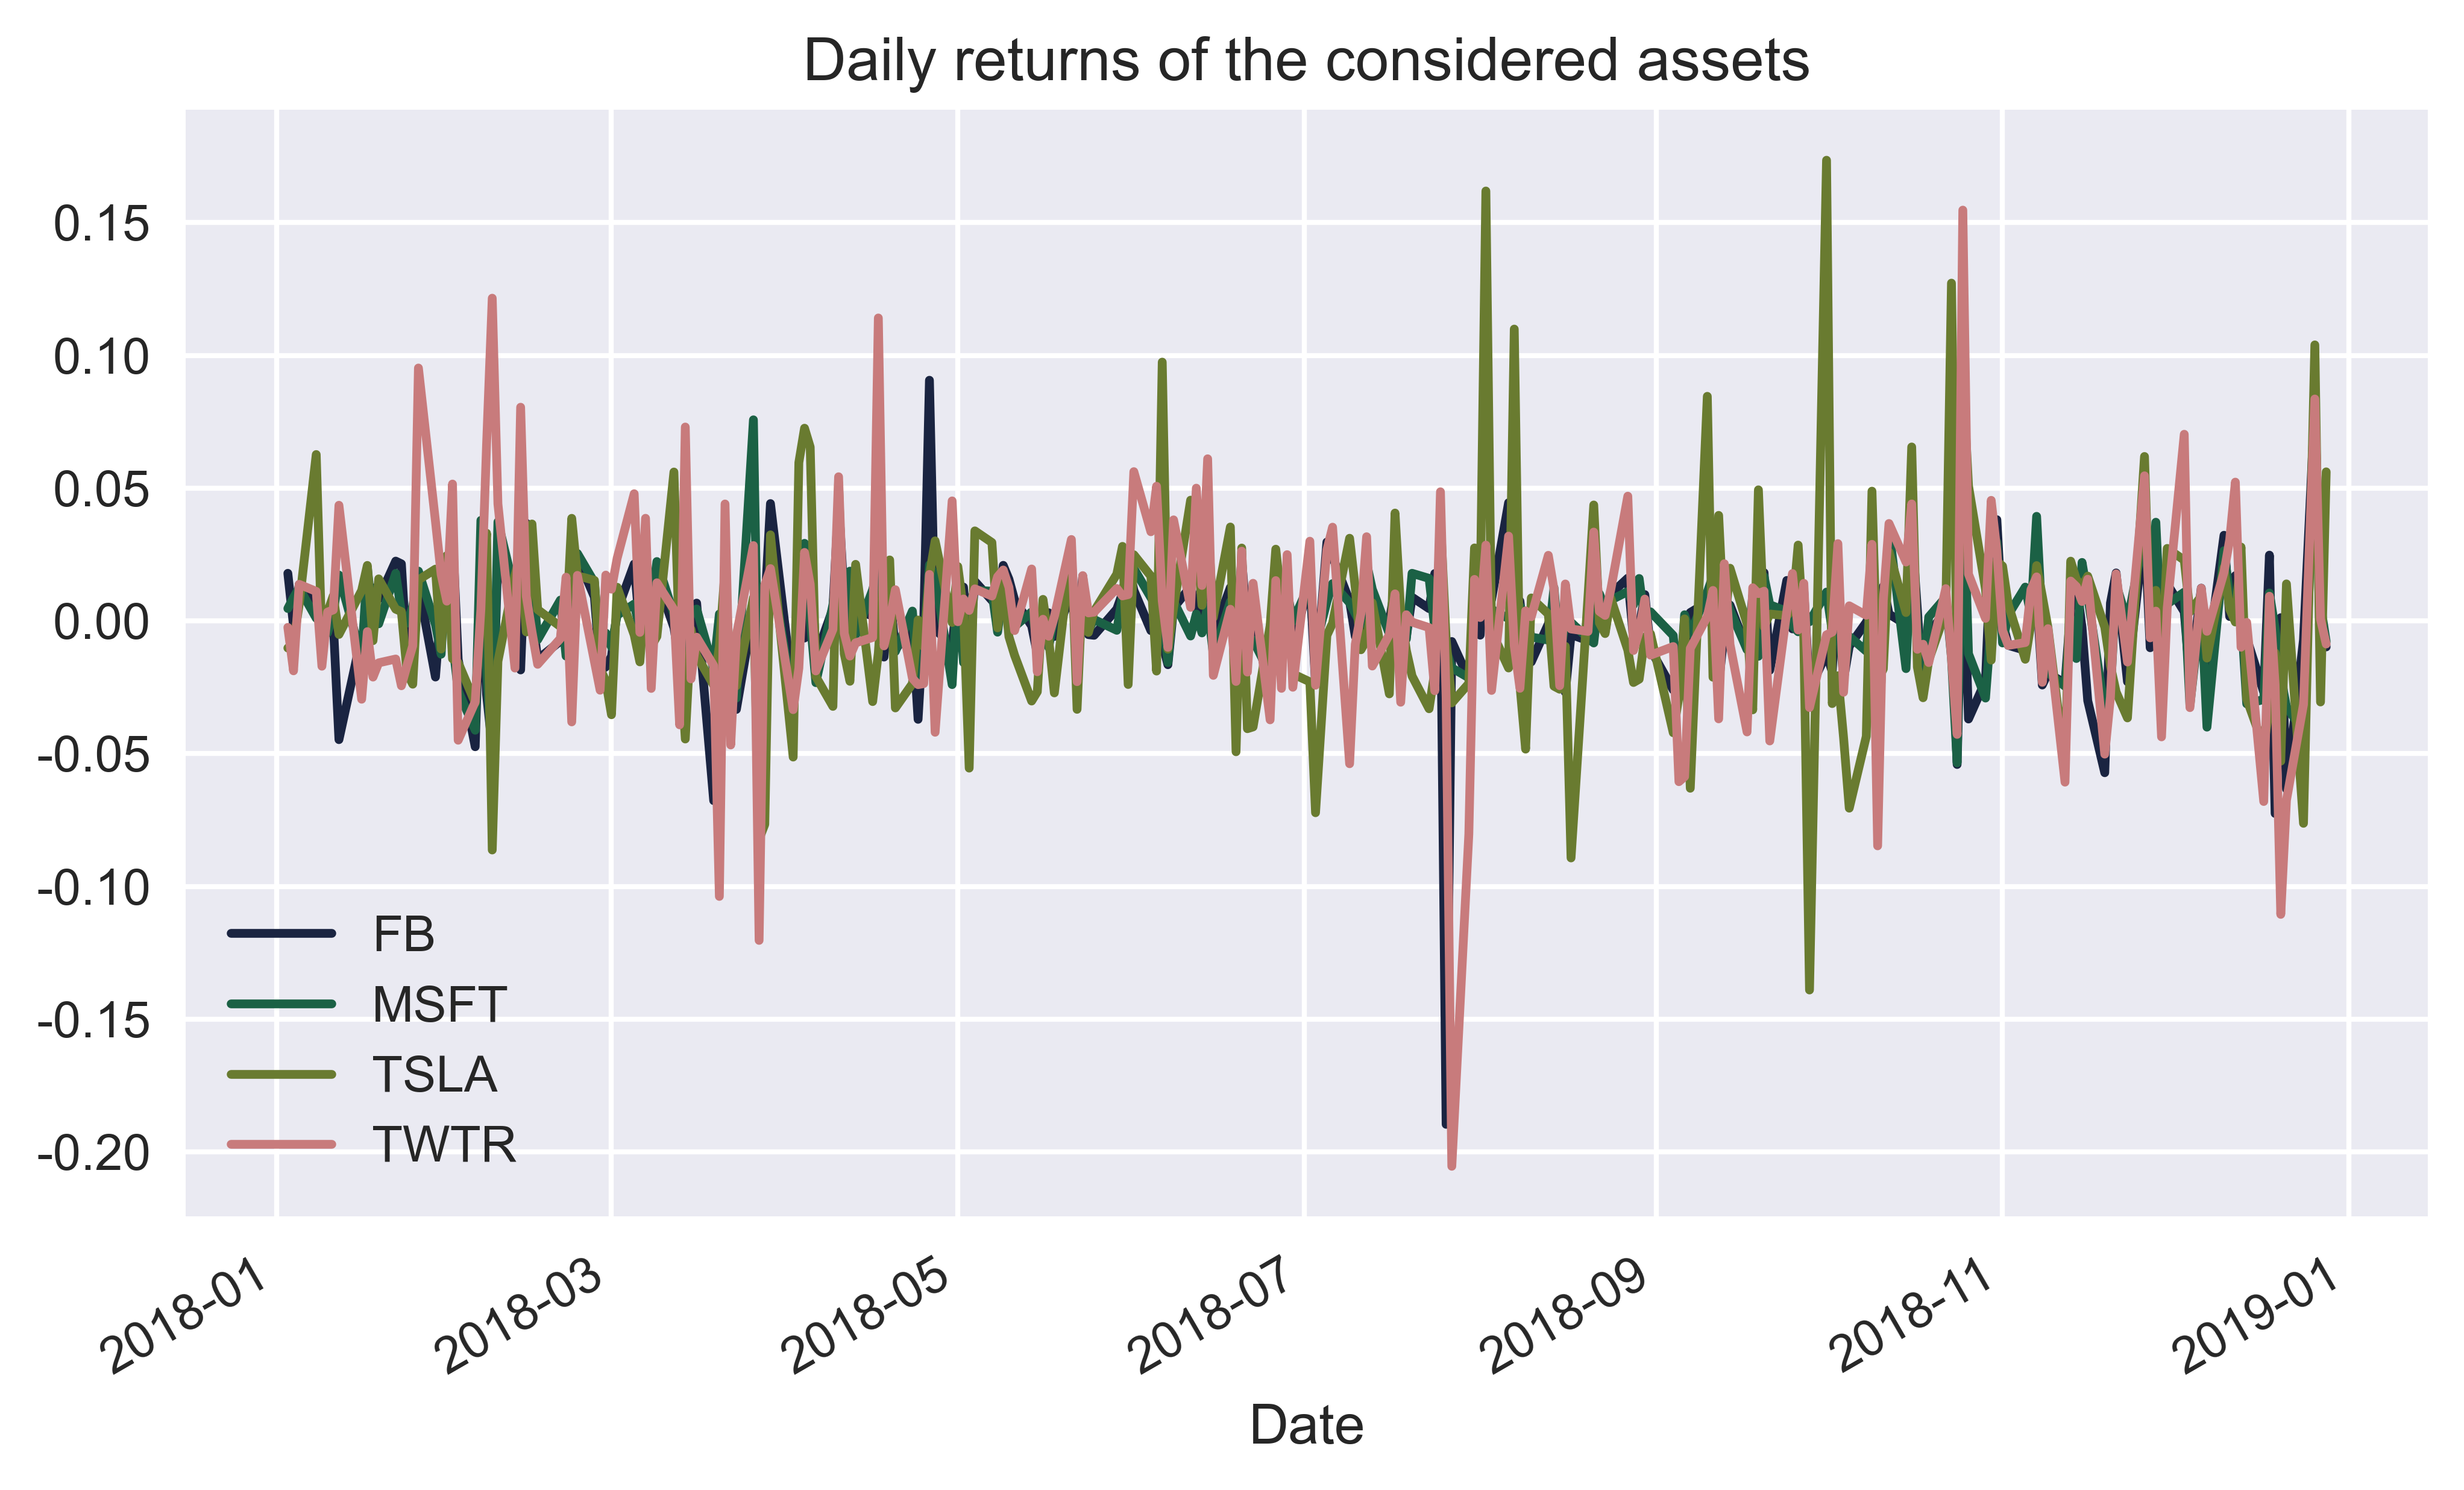

In [29]:
returns_df.plot(title='Daily returns of the considered assets');

5. Simulate random portfolio weights:
랜덤 포트폴리오 가중치를 시뮬레이션한다.

In [30]:
np.random.seed(42)
# np.random.random : 난수 (0~1 사이의) 행렬을 생성한다.
weights = np.random.random(size=(N_PORTFOLIOS, n_assets)) # (100000, 4)
# 행렬의 각 행을 합으로 나눈다.(가중치 총합을 1로 만들기 위해)
weights /=  np.sum(weights, axis=1)[:, np.newaxis] 

In [43]:
weights

array([[0.14102156, 0.35796222, 0.27560979, 0.22540643],
       [0.12620081, 0.1261813 , 0.04698284, 0.70063506],
       [0.2613905 , 0.30790022, 0.00895102, 0.42175826],
       ...,
       [0.24844023, 0.35095292, 0.34779874, 0.05280811],
       [0.26525555, 0.15257129, 0.28992551, 0.29224765],
       [0.12145388, 0.25651504, 0.39812299, 0.22390809]])

In [44]:
# MPT의 가정에 따라 가중치는 양수여야 하며 그 총합은 1이어야 한다..
0.14102156+0.35796222+0.27560979+0.22540643

1.0

In [34]:
weights.shape

(100000, 4)

6. Calculate portfolio metrics:
포트폴리오 지표를 계산한다.
- 예상 연간 포트폴리오 수익률을 계산하려면 가중치에 이전에 계산된 연간 평균을 곱해야한다.
- 표준 편차의 경우, 즉 과거 공분산을 사용해야 한다.
- 관심지표와는 관계없는 비대각(off-diagonal) 요소의 계산량이 빠르게 증가하기 때문이다. 벡터화 계산 방법은 비교적 적은 수의 시뮬레이션(~100)에 대해서만 for 루프보다 빠르다.

<img src="6stage.jpg">

In [35]:
portf_rtns = np.dot(weights, avg_returns) # 예상 연간 포폴 수익률

portf_vol = []
# 표준편차 구하는 식
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

7. Create a joint DataFrame with all data:
- 모든 데이터를 가진 DataFrame을 생성

In [36]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [39]:
portf_results_df.head()

returns  volatility  sharpe_ratio
0  0.173275    0.332381      0.521316
1  0.230926    0.456747      0.505589
2  0.140658    0.358532      0.392318
3 -0.039292    0.326682     -0.120275
4  0.144428    0.326933      0.441765

In [40]:
portf_results_df.shape

(100000, 3)

8. Locate the points creating the Efficient Frontier:
- 효율적 경계선을 생성하는 점을 알아낸다.
- linspace : np.linspace(start, stop, num)... 
- start : 배열의 시작값,
- stop : 배열의 끝 값
- num : start와 stop 사이를 몇 개의 일정한 간격으로 요소를 만들 것인지

In [37]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)   # 효율적 returns
portf_rtns = np.round(portf_rtns, 2)   # 그냥 returns

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip) # delete : 배열의 요소 삭제

In [41]:
# A = np.array([1,2,3,4,5])
# np.delete(A,0)


array([2, 3, 4, 5])

9. Plot the Efficient Frontier:
- 효율적 경계선을 도식화한다.

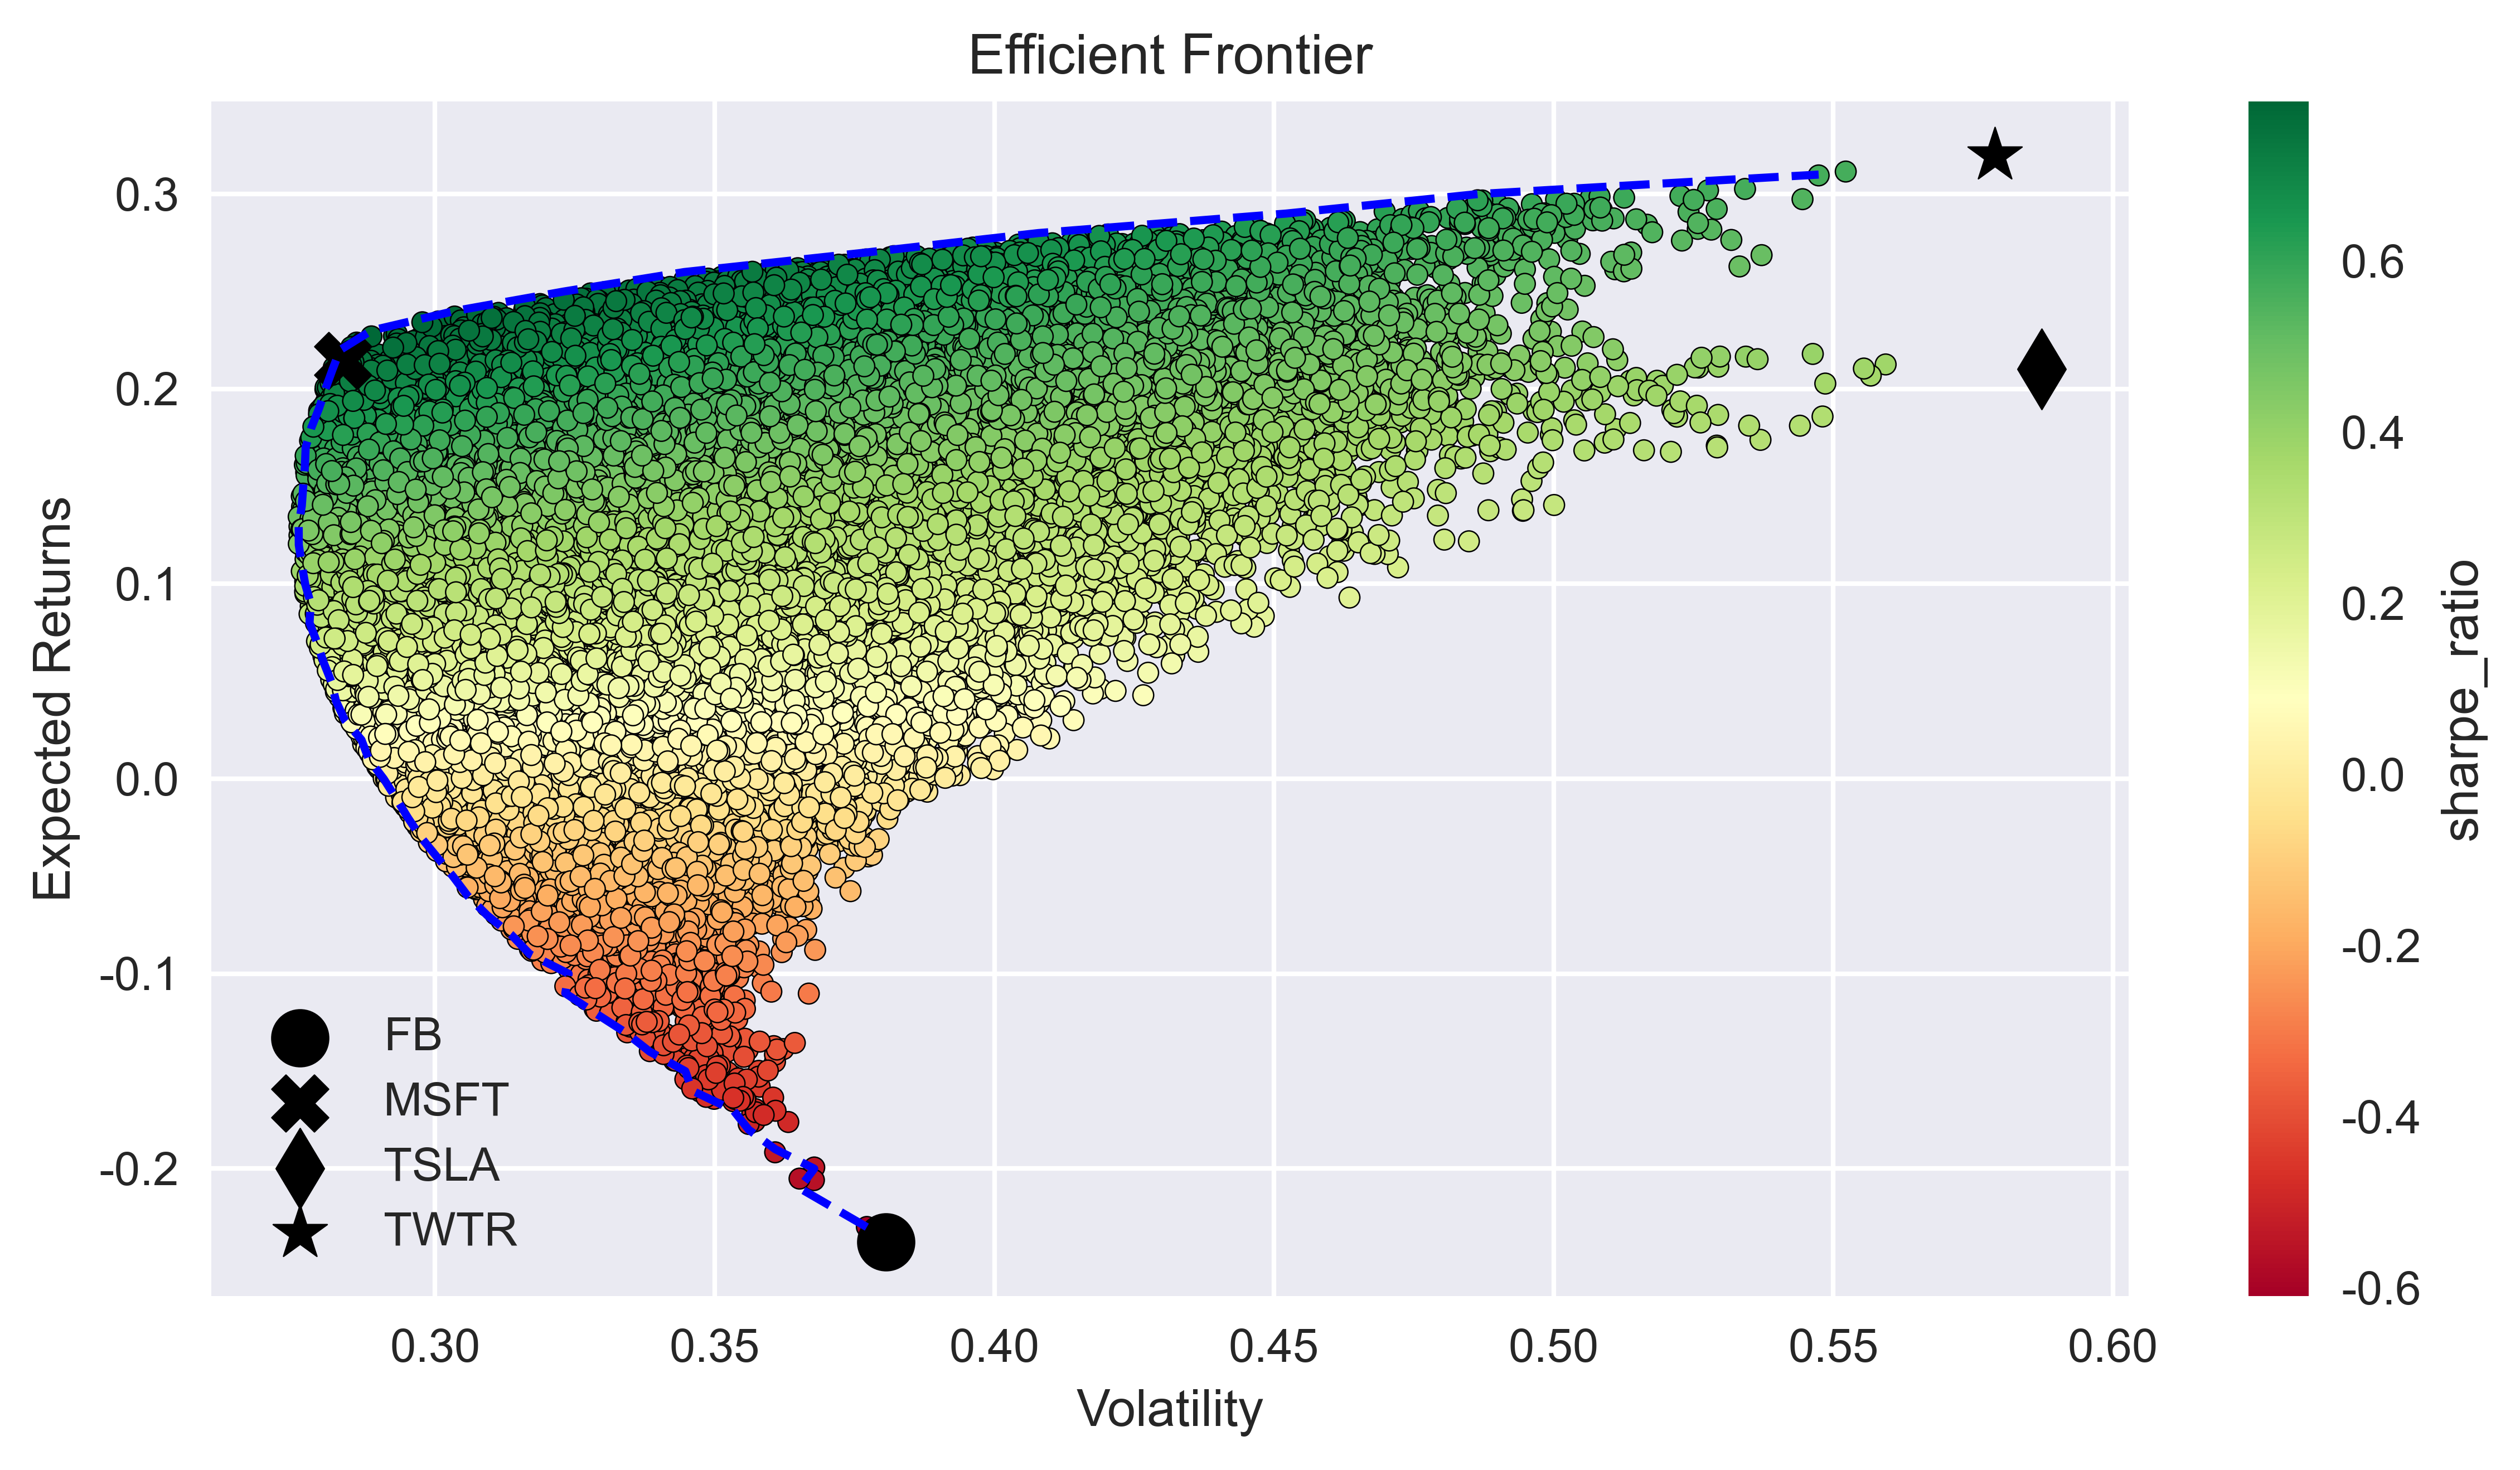

In [42]:
MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=RISKY_ASSETS[asset_index])
ax.legend()

plt.tight_layout()
plt.savefig('images/ch7_im8.png')
plt.show()

### 이 예에서는 무위험 금리를 0%로 가정했으므로 포트폴리오의 샤프 비율도 포트폴리오 수익률/포트폴리오 변동성으로 계산할 수 있다.
- 또 다른 가능한 방법은 2018년 동안의 평균 연간 무위험 금리를 계산하고 비율을 계산할 때 포트폴리오 초과 수익을 사용하는 것이다.

### 마지막 세 단계로 결과를 시각화했다.
- 1. 모든 관련 측정 항목을 pandas DataFrame에 넣었다.
- 2. 샘플에서 기대 수익률 배열을 만들었다. 이를 위해 계산된 포트폴리오 수익률의 최소값, 최댓값과 함께 np.linspace를 사용했다.(계산을 더 매끄럽게 하고자 숫자를 소수점 이하 두 자리로 반올림했다.)
- 각각의 예상 수익에 대해 관측 가능한 최소 변동성을 발견했다. 매치가 없다면(선형 공간에서 동일하게 퍼진 점들에서 발생할 수 있다.) 해당점을 건너뛴다.
- 3. 시뮬레이션된 포트폴리오, 개별 자산과 대략적인 효율적 경계선을 하나의 그림으로 나타냈다. 경계선 모양은 약간 들쭉날쭉하며, 이러한 모양은 일부 극한 지역에서 빈도가 낮은 시뮬레이션 값만 사용할 때 예상할 수 있는 일이다. 또한 시뮬레이션된 포트폴리오를 나타내는 점을 샤프 비율 값으로 채색했다.

### There's more
- 10만 개의 랜덤 포트폴리오를 시뮬레이션한 후 샤프 비율이 가장 높은 것(단위 위험당 최대 기대 수익률, 탄젠시(Tangency) 포트폴리오라고도 한다. 
- 또는 최소 변동성을 갖는 것을 조사할 수 있다. 
- 시뮬레이션된 포트폴리오 중에서 이러한 포트폴리로를 찾으려면 np.argmin과 np.argmax를 사용하면 배열에서 최소값/최대값의 인덱스를 반환한다.

In [45]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

### 최대 샤프 비율 포트폴리오
- 2018년 페이스북의 연간 평균 수익률이 마이너스이기 때문에 페이스북의 비중이 작다.

In [48]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 23.42% volatility: 29.77% sharpe_ratio: 78.68% 
Weights
FB: 0.01% MSFT: 75.18% TSLA: 5.80% TWTR: 19.00% 

### 최소 변동성 포트폴리오
- 마이크로소프트에 ~79% 가중치 : 이 주식의 변동성이 가장 낮기 떄문이다.(이는 공분산 행렬을 조사해보면 알 수 있다.)

In [49]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: 13.45% volatility: 27.56% sharpe_ratio: 48.79% 
Weights
FB: 17.80% MSFT: 78.75% TSLA: 2.94% TWTR: 0.50% 

### 두 가지 포트폴리오를 효율적 경계선 그림에 표시한다.
- 

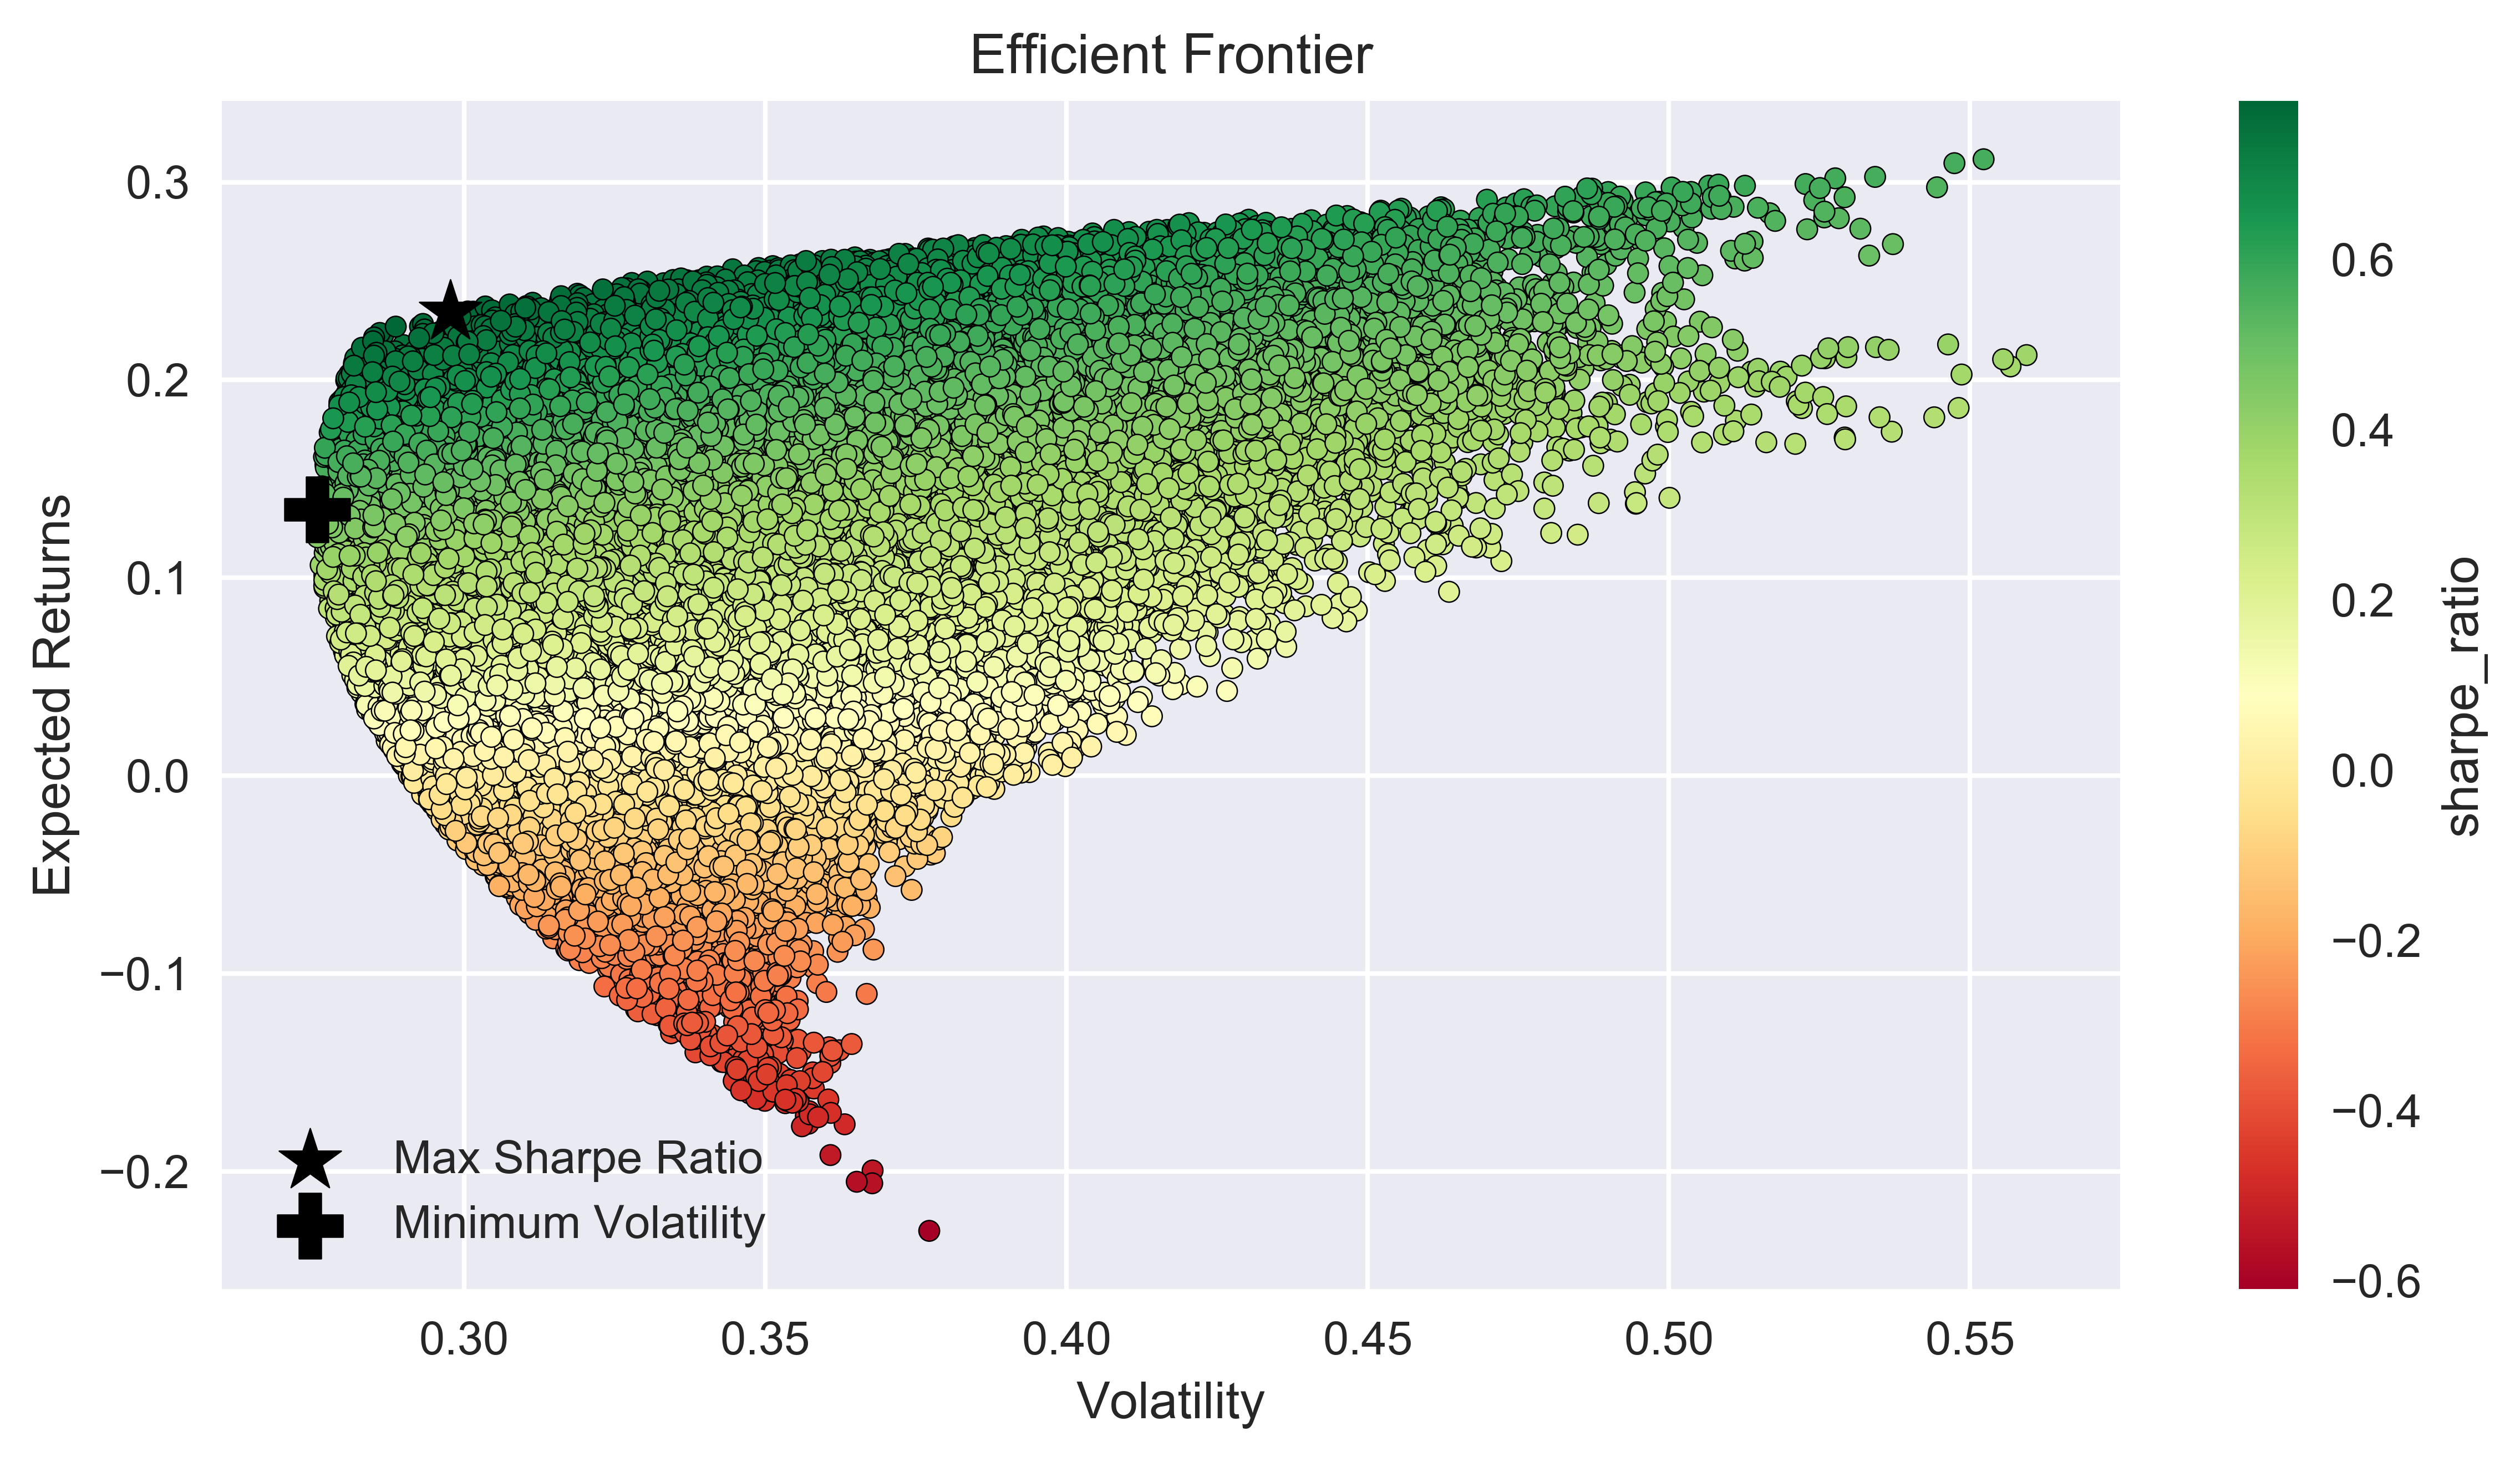

In [21]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, 
           y=max_sharpe_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio') # s: 마커 크기
ax.scatter(x=min_vol_portf.volatility, 
           y=min_vol_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
plt.savefig('images/ch7_im11.png')
plt.show()